# Building a Speech Recognition Engine in Keras

In this Notebook we will train a Convolutional Neural Network by feeding it speech signals (actually one word). After training we will try to predict the corresponding text of a .wav-file.

The task will be to classify audio between three classes: bed, cat and happy. Download the data.zip file from Canvas: in it, you will find three folders. Extract the folders in a sub-folder `data`. The name of the sub-folders is actually the label of the audio files in it. Each folder contains approximately 1700 audio files. Play some audio files randomly to get an overall idea.

<img src="./resources/single.png"  style="height: 200px"/>

As you know from the previous Notebook, directly feeding a speech signal to a ConvNet model won't do the job. There are some preprocessing steps you'll need to take. Basically we turn sound waves into numbers so that they can be used as input for a neural network.

## 1. Preprocess our sound data

In the previous Notebook we talked about the Fourier Transformation to transform our sound wave into a spectrogram. There are actually two ways to calculate such a spectrogram: MFCC (Mel Frequency Cepstral Coefficients) and FFT (Fast Fourier Transformation). The code below will use the first technique to preprocess the .wav-files in our three folders into spectrograms and create our test and training set.

First install Librosa, a Python package for music and audio analysis.

In [1]:
pip install --upgrade librosa


  Obtaining dependency information for librosa from https://files.pythonhosted.org/packages/e2/a2/4f639c1168d7aada749a896afb4892a831e2041bebdcf636aebfe9e86556/librosa-0.10.1-py3-none-any.whl.metadata
  Obtaining dependency information for audioread>=2.1.9 from https://files.pythonhosted.org/packages/57/8d/30aa32745af16af0a9a650115fbe81bde7c610ed5c21b381fca0196f3a7f/audioread-3.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for numba>=0.51.0 from https://files.pythonhosted.org/packages/3b/77/fdf609595d4f8f7f7e6e0fcaf11f7223d636cae4cb5c0805f46778c08a57/numba-0.58.1-cp310-cp310-win_amd64.whl.metadata
  Using cached soundfile-0.12.1-py2.py3-none-win_amd64.whl (1.0 MB)
     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     ---------------------------------------- 60.9/60.9 kB 3.2 MB/s eta 0:00:00
  Obtaining dependency information for soxr>=0.3.2 from https://files.pythonhosted.org/packages/3c/e7/89951b917600d02f7389e760696c32b70a80a96301d0a018a70a31


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Import the necessary Keras modules and a Python code library with some functions we will use later. By the way, you don't need to know the details of this code library.

In [10]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
# helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('library/preprocess.py')
# if this throws an error about the keras.utils to_categorical, go into the preprocess file, and adjust it to: 
# from tensorflow.keras.utils import to_categorical
from library.preprocess import *


Now run the code below to preprocess our sound data. Since computing MFCC is time consuming, we will do it only once and save the computed values in a .npy file which is named after the name of the label. After running the code you can find those .npy-files in the root folder of this lesson.

In [3]:
# second dimension of the feature is dim2
feature_dim_2 = 11

# save data to array file first
save_data_to_array(max_len=feature_dim_2)

Saving vectors of label - 'happy': 100%|██████████| 1740/1740 [00:18<00:00, 92.39it/s]


## 2. Prepare the train and test set

We'll take advantage of scikit-learn function `train_test_split` which will automatically split the whole dataset.

In [4]:
# loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# feature dimension
feature_dim_1 = 20
channel = 1

# reshaping to perform 2D convolution, there is only one channel (normally for images 3: RGB)
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

# one hot encoding (already explained in the Computer Vision Lesson, CIFAR-10 )
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

## 3. Build the model and train it

Finally it is time to build our CNN and train it with the train data. The code below has no secrets anymore.

In [8]:
epochs = 50
batch_size = 100
verbose = 1

class_names =  ['bed', 'cat', 'happy']
num_classes = len(class_names)


model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)),
    layers.Conv2D(48, kernel_size=(2, 2), activation='relu'),
    layers.Conv2D(120, kernel_size=(2, 2), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    # Hidden layer: Add a Dense layer, aka a fully or densely connected layer of 128 neurons, and let them use the 'ReLu'-squishing or activation function
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    # Output layer: Add a Dense layer of 10 neurons (because we have 10 possible output labels), and link those neurons together in a group, via the 'softmax'-activation function
    layers.Dense(num_classes, activation='softmax')
])


model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    
history = model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Epoch 1/50
32/32 [==============================] - 3s 56ms/step - loss: 1.3472 - accuracy: 0.4339 - val_loss: 0.8487 - val_accuracy: 0.7149
Epoch 2/50
32/32 [==============================] - 2s 50ms/step - loss: 0.7600 - accuracy: 0.6822 - val_loss: 0.4844 - val_accuracy: 0.8152
Epoch 3/50
32/32 [==============================] - 2s 49ms/step - loss: 0.5656 - accuracy: 0.7880 - val_loss: 0.3862 - val_accuracy: 0.8558
Epoch 4/50
32/32 [==============================] - 1s 47ms/step - loss: 0.4177 - accuracy: 0.8504 - val_loss: 0.2949 - val_accuracy: 0.8944
Epoch 5/50
32/32 [==============================] - 2s 48ms/step - loss: 0.3230 - accuracy: 0.8845 - val_loss: 0.2834 - val_accuracy: 0.8992
Epoch 6/50
32/32 [==============================] - 2s 47ms/step - loss: 0.2812 - accuracy: 0.9009 - val_loss: 0.2688 - val_accuracy: 0.9001
Epoch 7/50
32/32 [==============================] - 2s 49ms/step - loss: 0.2612 - accuracy: 0.9122 - val_loss: 0.3050 - val_accuracy: 0.8852
Epoch 8/50
32

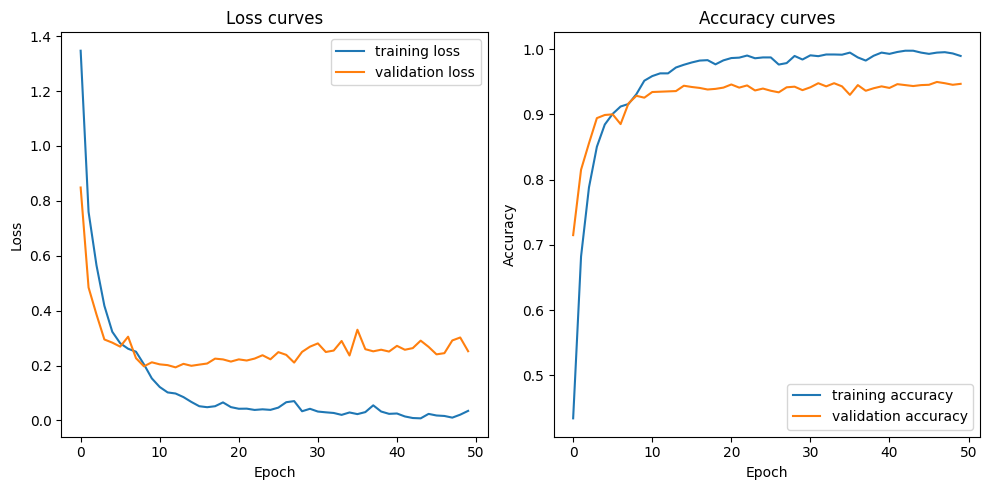

In [11]:
# Create a figure and a grid of subplots with a single call
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot the loss curves on the first subplot
ax1.plot(history.history['loss'], label='training loss')
ax1.plot(history.history['val_loss'], label='validation loss')
ax1.set_title('Loss curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the accuracy curves on the second subplot
ax2.plot(history.history['accuracy'], label='training accuracy')
ax2.plot(history.history['val_accuracy'], label='validation accuracy')
ax2.set_title('Accuracy curves')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust the spacing between subplots
fig.tight_layout()

# Show the figure
plt.show()

## 4. Predict

In the folder `data_test` you will find some .wav-files to test your model with. Since we achieved a pretty high accuracy, all these files should predict the correct corresponding text. Maybe you can try if this is still the case if you pronounce the words yourself?

In [12]:
sample = wav2mfcc('./data_test/bed_0.wav')
sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)

predicted_index = np.argmax(model.predict(sample_reshaped))

print(class_names[predicted_index])

1/1 [==============================] - 0s 110ms/step
bed


## 5. Exercise

In the `data_fruit` folder you will find another dataset for Speech Recognition. Use this dataset as input and build and train a model. Can you achieve a high accuracy? Try to predict your own words.